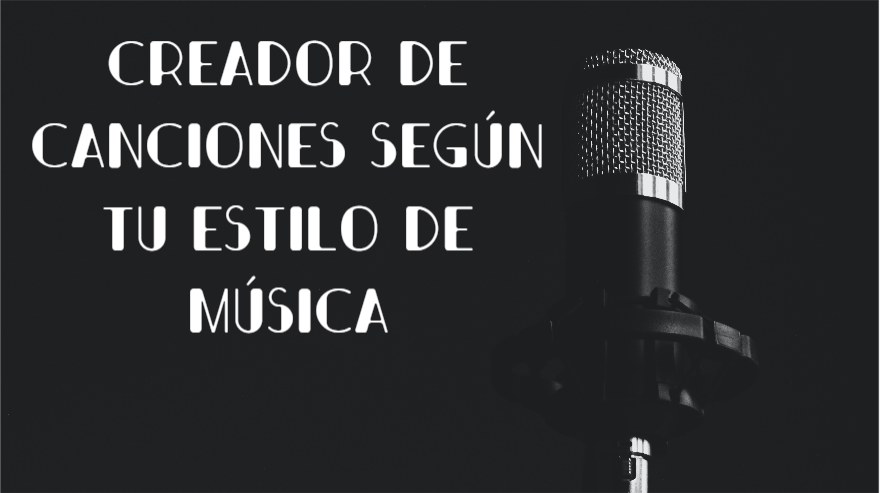

<p style='text-align: justify;'> Primero se va a importar los paquetes de Tensorflow y de Keras. Estas dos son bibliotecas de código abierto. Especialmente Keras es una biblioteca de Redes Neuronales de Código Abierto escrita en Python y es capaz de ejecutarse sobre TensorFlow. Además importaremos el paquete de numpy ya que se trabajarán con vectores.</p>

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

#### ELECCIÓN DEL ESTILO DE MÚSICA

Introduce el estilo de música que quieras crear, se debe introducir una de las siguientes palabras:
- Pop.txt
- Rock.txt
- Country.txt
- Rap.txt

In [2]:
data = open(input("Estilo de música: ")).read()

Estilo de música: Pop.txt


<p style='text-align: justify;'> Una se introduce en data el archivo txt se realizará una serie de transformaciones para crear el siguiente corpus y es la transformación de todas las palabras en minúsculas y su división con el método split para separar cada cadena usando un separador \n para crear una nueva línea y así crear una lista de oraciones en Python dado partir de los datos. Por otro lado se usa el tokenizer y el método fit_on_texts al corpus para crear un diccionario de palabras. El valor 0 está reservado para el relleno. Por lo tanto, un número entero más bajo significa una palabra más frecuente (a menudo, las primeras son palabras vacías porque aparecen mucho). Este es un par de valores clave con la clave siendo la palabra y el valor es el token de esa palabra. Por último se observa el número total de palabras en el corpus, obteniendo la longitud de su índice de palabras. Se añade uno a esta variable para considerar palabras de un vocabulario externo. </p>

In [3]:
tokenizer = Tokenizer()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

<p style='text-align: justify;'> En este siguiente paso se convertirá el corpus en datos de entrenamiento para llevar a cabo el modelo. En primer lugar, las x de entrenamiento se llamarán secuencias de entrada, y esta será una lista de Python. Luego, para cada línea en el corpus generaremos una lista de tokens usando los tokenizers, textos al método de secuencias. Esto convertirá una línea de texto en una lista de los tokens que representan las palabras. 

Luego se va a iterar sobre esta lista de tokens y crear un número de secuencias de n-gramos, es decir, las dos primeras palabras de la oración o una secuencia, luego las tres primeras son otra secuencia, etc. El resultado de esto será, para la primera línea de la canción, la siguiente entrada secuencias que se generarán. El mismo proceso sucederá para cada línea y las secuencias de entrada son simplemente oraciones que se dividen en frases, las dos primeras palabras, las tres primeras palabras, etc.

Luego se necesita encontrar la longitud de la frase más larga en el corpus. Para hacer esto, se itera sobre todas las secuencias y se encuentra la más larga. Una vez que se tenga la secuencia más larga, lo siguiente que se tiene que hacer es rellenar todas las secuencias para que tengan la misma longitud. Se usa pre-pad con ceros para que sea más fácil extraer la etiqueta. 

Ahora, que tenemos las secuencias, lo siguiente que tenemos que hacer es convertirlas en x e y los valores de entrada y sus etiquetas. Todo lo que se tiene que hacer es tomar todo menos el último carácter como la "x" y luego usar el último carácter como la "y" en nuestra etiqueta. Como vemos al utilizar el pre-relleno es mucho más fácil obtener la etiqueta simplemente cogiendo el último token. </p>

In [4]:
#  Se crean las secuencias de entrada usando la lista de tokens 
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Secuencias pad
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Se crean los predictores y etiquetar 
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

<p style='text-align: justify;'> Se introduce una serie de modelos para que aprendan de los datos obtenidos anteriormente. Se comienza con un modelo secuencial donde se introducen el número total de palabras y se van a trazar en 100 dimensiones. Además se creará una LSTM bidireccional con 150 unidades y otra LSTM de 100 unidades. Entre ellas se introduce un método de Dropout que trata de desactivar un numero de neuronas de una red neuronal de forma aleatoria. Además se agregan dos capas densas y al final para el número total de palabras se activan con el softmax. 

Para compilarlo al ser categórico se realiza una entropía cruzada categórica y como optimizador el Adam. Debido a que es un problema complicado se van a introducir 150 épocas para entrenar el modelo y se podrá observar por ello que a medida que se empieza a entrenar la precisión es muy baja, pero mejorará con el tiempo. </p>

In [5]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 100)           164000    
_________________________________________________________________
bidirectional (Bidirectional (None, 26, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 26, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 820)               82820     
_________________________________________________________________
dense_1 (Dense)              (None, 1640)              1346440   
Total params: 2,054,860
Trainable params: 2,054,860
Non-trainable params: 0
______________________________________________

In [6]:
history = model.fit(predictors, label, epochs=150, verbose=1)

Epoch 1/150
493/493 [==============================] - 30s 62ms/step - loss: 6.2623 - accuracy: 0.0327
Epoch 2/150
493/493 [==============================] - 31s 63ms/step - loss: 5.7394 - accuracy: 0.0401
Epoch 3/150
493/493 [==============================] - 31s 63ms/step - loss: 5.5100 - accuracy: 0.0498
Epoch 4/150
493/493 [==============================] - 32s 65ms/step - loss: 5.3392 - accuracy: 0.0596
Epoch 5/150
493/493 [==============================] - 32s 65ms/step - loss: 5.1902 - accuracy: 0.0720
Epoch 6/150
493/493 [==============================] - 31s 64ms/step - loss: 5.0428 - accuracy: 0.0851
Epoch 7/150
493/493 [==============================] - 30s 62ms/step - loss: 4.8832 - accuracy: 0.1035
Epoch 8/150
493/493 [==============================] - 28s 58ms/step - loss: 4.7239 - accuracy: 0.1180
Epoch 9/150
493/493 [==============================] - 29s 58ms/step - loss: 4.5806 - accuracy: 0.1398
Epoch 10/150
493/493 [==============================] - 28s 57ms/step - l

Se dibujaran las siguientes gráficas con el método plot para ver el Training accuracy y el Training Loss y observar como de bueno es el modelo.

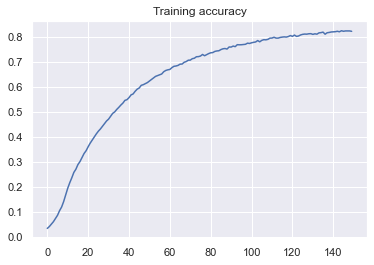

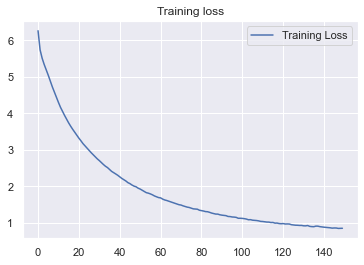

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set()

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

<p style='text-align: justify;'>En el siguiente paso del código se realizará la predicción del texto. Esto consiste en la predicción de la siguiente palabra y así a partir de un "texto semilla" el modelo observará cual es la palabra que más probabilidades tiene de seguir a las anteriores y así crear la canción. 

Llamamos al texto semilla y el número de palabras que quiero que prediga, en este caso se introduce 250.  Este código rellenará la secuencia a partir de la semilla para que coincida con los del conjunto de entrenamiento. En la predicción la palabra que no está la ignorará y obtendrá la siguiente secuencia. 

Por lo tanto lo que sea realizará una búsqueda inversa en los elementos del índice de palabras para convertir el token de nuevo en una palabra y agregar eso a nuestros textos iniciales y así crear el siguiente texto. </p>

In [58]:
seed_text = "When I wake up in the morning and you're not right there,"
next_words = 150
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

La canción creada será por tanto:

In [59]:
print(seed_text)

When I wake up in the morning and you're not right there, anyhow one more time i wrote better yea have no nice time when they come for you and so love me the fire last we fire this generation gap so much fire people in from mandeville to sligoville coffin come shining coming in coming in in from from from from from from from from the was coming in in a slogans was in from from the was let's oh in the one heart one heart one heart so much love so soul fire of way coming in from the cold it's in the cold in away let's get coming in coming in in coming in in from from from from from from the been living why arms let's oh was so africans tonight is is in from coming in in the love of the last slave ooh right life in and we're jammin' jammin' coming in coming in in from
